<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:34:42] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


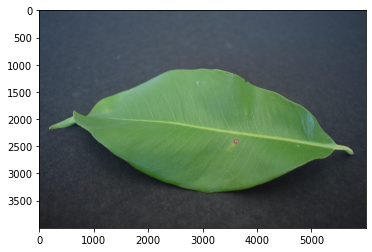

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

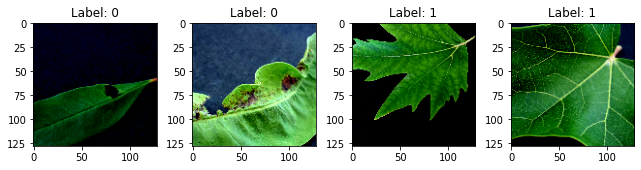

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:34:48] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:34:49] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2633783508519993 samples/sec                   batch loss = 1.6403822898864746 | accuracy = 0.4


Epoch[1] Batch[10] Speed: 1.2733593385629676 samples/sec                   batch loss = 0.9706486463546753 | accuracy = 0.575


Epoch[1] Batch[15] Speed: 1.260693703991697 samples/sec                   batch loss = 1.1312800645828247 | accuracy = 0.6333333333333333


Epoch[1] Batch[20] Speed: 1.2612712686900975 samples/sec                   batch loss = 1.2670031785964966 | accuracy = 0.625


Epoch[1] Batch[25] Speed: 1.2634214491363631 samples/sec                   batch loss = 0.6497657895088196 | accuracy = 0.6


Epoch[1] Batch[30] Speed: 1.270002624451577 samples/sec                   batch loss = 1.3010680675506592 | accuracy = 0.6


Epoch[1] Batch[35] Speed: 1.2628933411969894 samples/sec                   batch loss = 0.6258086562156677 | accuracy = 0.5857142857142857


Epoch[1] Batch[40] Speed: 1.2661077058381476 samples/sec                   batch loss = 0.3944428265094757 | accuracy = 0.5875


Epoch[1] Batch[45] Speed: 1.2644257194310347 samples/sec                   batch loss = 0.9376128911972046 | accuracy = 0.6111111111111112


Epoch[1] Batch[50] Speed: 1.270117325927578 samples/sec                   batch loss = 0.7589626908302307 | accuracy = 0.615


Epoch[1] Batch[55] Speed: 1.271643777575487 samples/sec                   batch loss = 0.48815739154815674 | accuracy = 0.6045454545454545


Epoch[1] Batch[60] Speed: 1.2661141075836746 samples/sec                   batch loss = 0.4101059138774872 | accuracy = 0.6


Epoch[1] Batch[65] Speed: 1.271132658793883 samples/sec                   batch loss = 0.76105797290802 | accuracy = 0.5807692307692308


Epoch[1] Batch[70] Speed: 1.2671836294400045 samples/sec                   batch loss = 0.42585164308547974 | accuracy = 0.575


Epoch[1] Batch[75] Speed: 1.265314295363558 samples/sec                   batch loss = 0.4148569107055664 | accuracy = 0.5733333333333334


Epoch[1] Batch[80] Speed: 1.272419670867941 samples/sec                   batch loss = 0.6774400472640991 | accuracy = 0.571875


Epoch[1] Batch[85] Speed: 1.2685151146956684 samples/sec                   batch loss = 0.7785947918891907 | accuracy = 0.5735294117647058


Epoch[1] Batch[90] Speed: 1.268655736772712 samples/sec                   batch loss = 0.5123029351234436 | accuracy = 0.5833333333333334


Epoch[1] Batch[95] Speed: 1.2693934099680866 samples/sec                   batch loss = 0.3790528476238251 | accuracy = 0.5815789473684211


Epoch[1] Batch[100] Speed: 1.26712725851178 samples/sec                   batch loss = 0.3654225468635559 | accuracy = 0.5875


Epoch[1] Batch[105] Speed: 1.2640077064526247 samples/sec                   batch loss = 2.3653125762939453 | accuracy = 0.5904761904761905


Epoch[1] Batch[110] Speed: 1.265098187306622 samples/sec                   batch loss = 0.3818972706794739 | accuracy = 0.5931818181818181


Epoch[1] Batch[115] Speed: 1.2648564055516054 samples/sec                   batch loss = 0.23525896668434143 | accuracy = 0.6065217391304348


Epoch[1] Batch[120] Speed: 1.2609345601652022 samples/sec                   batch loss = 0.783916175365448 | accuracy = 0.6125


Epoch[1] Batch[125] Speed: 1.261832564638472 samples/sec                   batch loss = 0.8242336511611938 | accuracy = 0.61


Epoch[1] Batch[130] Speed: 1.2647235841489817 samples/sec                   batch loss = 0.5859392881393433 | accuracy = 0.6153846153846154


Epoch[1] Batch[135] Speed: 1.2685139637568217 samples/sec                   batch loss = 0.4436906576156616 | accuracy = 0.6148148148148148


Epoch[1] Batch[140] Speed: 1.2614070646607718 samples/sec                   batch loss = 0.5939761400222778 | accuracy = 0.6107142857142858


Epoch[1] Batch[145] Speed: 1.2644110442851686 samples/sec                   batch loss = 0.8319440484046936 | accuracy = 0.6137931034482759


Epoch[1] Batch[150] Speed: 1.2669739626118737 samples/sec                   batch loss = 0.4506629407405853 | accuracy = 0.6133333333333333


Epoch[1] Batch[155] Speed: 1.2639273363765537 samples/sec                   batch loss = 0.2585754990577698 | accuracy = 0.6209677419354839


Epoch[1] Batch[160] Speed: 1.2667609218687295 samples/sec                   batch loss = 0.24853606522083282 | accuracy = 0.6203125


Epoch[1] Batch[165] Speed: 1.263273328936493 samples/sec                   batch loss = 0.6126044988632202 | accuracy = 0.6257575757575757


Epoch[1] Batch[170] Speed: 1.2598345918626261 samples/sec                   batch loss = 0.7495380640029907 | accuracy = 0.6220588235294118


Epoch[1] Batch[175] Speed: 1.2627087550116896 samples/sec                   batch loss = 0.26983529329299927 | accuracy = 0.6257142857142857


Epoch[1] Batch[180] Speed: 1.2632965387987882 samples/sec                   batch loss = 0.6586126089096069 | accuracy = 0.6291666666666667


Epoch[1] Batch[185] Speed: 1.263946951826665 samples/sec                   batch loss = 0.5049480199813843 | accuracy = 0.6310810810810811


Epoch[1] Batch[190] Speed: 1.2628510393904793 samples/sec                   batch loss = 0.49018728733062744 | accuracy = 0.6381578947368421


Epoch[1] Batch[195] Speed: 1.261122514629532 samples/sec                   batch loss = 0.8959337472915649 | accuracy = 0.6410256410256411


Epoch[1] Batch[200] Speed: 1.26535485366737 samples/sec                   batch loss = 0.38332197070121765 | accuracy = 0.6425


Epoch[1] Batch[205] Speed: 1.259238777179828 samples/sec                   batch loss = 0.7541345357894897 | accuracy = 0.6402439024390244


Epoch[1] Batch[210] Speed: 1.2598486879404664 samples/sec                   batch loss = 0.35137617588043213 | accuracy = 0.6428571428571429


Epoch[1] Batch[215] Speed: 1.2576926326338138 samples/sec                   batch loss = 0.36106109619140625 | accuracy = 0.6441860465116279


Epoch[1] Batch[220] Speed: 1.2562843172103644 samples/sec                   batch loss = 0.608625054359436 | accuracy = 0.6443181818181818


Epoch[1] Batch[225] Speed: 1.2597459546284049 samples/sec                   batch loss = 0.7047061920166016 | accuracy = 0.6466666666666666


Epoch[1] Batch[230] Speed: 1.2582799069378352 samples/sec                   batch loss = 0.5523342490196228 | accuracy = 0.65


Epoch[1] Batch[235] Speed: 1.2644715576322392 samples/sec                   batch loss = 1.1930456161499023 | accuracy = 0.6457446808510638


Epoch[1] Batch[240] Speed: 1.266027450641261 samples/sec                   batch loss = 0.5426130294799805 | accuracy = 0.6447916666666667


Epoch[1] Batch[245] Speed: 1.2597224967007514 samples/sec                   batch loss = 0.3104734420776367 | accuracy = 0.6469387755102041


Epoch[1] Batch[250] Speed: 1.2666098183079648 samples/sec                   batch loss = 0.2929443120956421 | accuracy = 0.644


Epoch[1] Batch[255] Speed: 1.2661289178401056 samples/sec                   batch loss = 0.9091317057609558 | accuracy = 0.6450980392156863


Epoch[1] Batch[260] Speed: 1.264489665113905 samples/sec                   batch loss = 0.4181790053844452 | accuracy = 0.6451923076923077


Epoch[1] Batch[265] Speed: 1.2608857561425584 samples/sec                   batch loss = 0.5392061471939087 | accuracy = 0.6471698113207547


Epoch[1] Batch[270] Speed: 1.2636285141179313 samples/sec                   batch loss = 0.8747375011444092 | accuracy = 0.649074074074074


Epoch[1] Batch[275] Speed: 1.264858980254974 samples/sec                   batch loss = 0.6673501133918762 | accuracy = 0.6527272727272727


Epoch[1] Batch[280] Speed: 1.262060469799102 samples/sec                   batch loss = 0.6013162136077881 | accuracy = 0.6526785714285714


Epoch[1] Batch[285] Speed: 1.2659657374938351 samples/sec                   batch loss = 0.5164214372634888 | accuracy = 0.6526315789473685


Epoch[1] Batch[290] Speed: 1.2630695182946605 samples/sec                   batch loss = 0.4777340292930603 | accuracy = 0.6551724137931034


Epoch[1] Batch[295] Speed: 1.264448018681363 samples/sec                   batch loss = 0.8663356304168701 | accuracy = 0.6559322033898305


Epoch[1] Batch[300] Speed: 1.264123994523129 samples/sec                   batch loss = 0.6462542414665222 | accuracy = 0.6566666666666666


Epoch[1] Batch[305] Speed: 1.2674888277401586 samples/sec                   batch loss = 0.8168423771858215 | accuracy = 0.6573770491803279


Epoch[1] Batch[310] Speed: 1.2635419115907107 samples/sec                   batch loss = 0.6284404397010803 | accuracy = 0.6588709677419354


Epoch[1] Batch[315] Speed: 1.2623958802044848 samples/sec                   batch loss = 1.2386106252670288 | accuracy = 0.6611111111111111


Epoch[1] Batch[320] Speed: 1.2655757273289325 samples/sec                   batch loss = 1.3260488510131836 | accuracy = 0.66171875


Epoch[1] Batch[325] Speed: 1.264925067895451 samples/sec                   batch loss = 0.8130367398262024 | accuracy = 0.6623076923076923


Epoch[1] Batch[330] Speed: 1.2587597733256204 samples/sec                   batch loss = 0.5373137593269348 | accuracy = 0.6613636363636364


Epoch[1] Batch[335] Speed: 1.2679610833086639 samples/sec                   batch loss = 0.6563140749931335 | accuracy = 0.664179104477612


Epoch[1] Batch[340] Speed: 1.2660218140515067 samples/sec                   batch loss = 0.6498843431472778 | accuracy = 0.6647058823529411


Epoch[1] Batch[345] Speed: 1.261320007734573 samples/sec                   batch loss = 1.2669111490249634 | accuracy = 0.6652173913043479


Epoch[1] Batch[350] Speed: 1.2589654074498247 samples/sec                   batch loss = 0.7202462553977966 | accuracy = 0.665


Epoch[1] Batch[355] Speed: 1.2628576934194045 samples/sec                   batch loss = 1.2531070709228516 | accuracy = 0.6647887323943662


Epoch[1] Batch[360] Speed: 1.265925713142678 samples/sec                   batch loss = 0.33051204681396484 | accuracy = 0.6652777777777777


Epoch[1] Batch[365] Speed: 1.261416548711916 samples/sec                   batch loss = 0.43888595700263977 | accuracy = 0.665068493150685


Epoch[1] Batch[370] Speed: 1.262031894084865 samples/sec                   batch loss = 0.16413013637065887 | accuracy = 0.6662162162162162


Epoch[1] Batch[375] Speed: 1.2600866659882 samples/sec                   batch loss = 0.5362831950187683 | accuracy = 0.6666666666666666


Epoch[1] Batch[380] Speed: 1.2576165516008937 samples/sec                   batch loss = 0.6568323969841003 | accuracy = 0.6690789473684211


Epoch[1] Batch[385] Speed: 1.2616824447010508 samples/sec                   batch loss = 0.6236558556556702 | accuracy = 0.6681818181818182


Epoch[1] Batch[390] Speed: 1.2593875598402189 samples/sec                   batch loss = 0.25280746817588806 | accuracy = 0.6698717948717948


Epoch[1] Batch[395] Speed: 1.2594676372332487 samples/sec                   batch loss = 0.23479145765304565 | accuracy = 0.6708860759493671


Epoch[1] Batch[400] Speed: 1.2586230359634318 samples/sec                   batch loss = 0.5638265013694763 | accuracy = 0.67125


Epoch[1] Batch[405] Speed: 1.257886883708404 samples/sec                   batch loss = 0.22478105127811432 | accuracy = 0.6709876543209876


Epoch[1] Batch[410] Speed: 1.2580847797397643 samples/sec                   batch loss = 0.348614901304245 | accuracy = 0.6725609756097561


Epoch[1] Batch[415] Speed: 1.2539972000876 samples/sec                   batch loss = 0.6293651461601257 | accuracy = 0.6698795180722892


Epoch[1] Batch[420] Speed: 1.2584734898850098 samples/sec                   batch loss = 0.42774805426597595 | accuracy = 0.6696428571428571


Epoch[1] Batch[425] Speed: 1.2540318807171442 samples/sec                   batch loss = 0.531671404838562 | accuracy = 0.6676470588235294


Epoch[1] Batch[430] Speed: 1.2603711274530796 samples/sec                   batch loss = 0.6573154330253601 | accuracy = 0.6686046511627907


Epoch[1] Batch[435] Speed: 1.2579417752233872 samples/sec                   batch loss = 0.6437998414039612 | accuracy = 0.6672413793103448


Epoch[1] Batch[440] Speed: 1.2552085020595793 samples/sec                   batch loss = 0.4859318137168884 | accuracy = 0.6676136363636364


Epoch[1] Batch[445] Speed: 1.2565212327784774 samples/sec                   batch loss = 0.6146913766860962 | accuracy = 0.6674157303370787


Epoch[1] Batch[450] Speed: 1.25592958141335 samples/sec                   batch loss = 0.3975532352924347 | accuracy = 0.6683333333333333


Epoch[1] Batch[455] Speed: 1.2662994040612237 samples/sec                   batch loss = 1.189542293548584 | accuracy = 0.6675824175824175


Epoch[1] Batch[460] Speed: 1.2625537709136703 samples/sec                   batch loss = 0.4720799922943115 | accuracy = 0.6684782608695652


Epoch[1] Batch[465] Speed: 1.2671483132801658 samples/sec                   batch loss = 0.37876322865486145 | accuracy = 0.6688172043010753


Epoch[1] Batch[470] Speed: 1.2598803816163613 samples/sec                   batch loss = 0.36183634400367737 | accuracy = 0.6686170212765957


Epoch[1] Batch[475] Speed: 1.2544549513133885 samples/sec                   batch loss = 1.0536398887634277 | accuracy = 0.6694736842105263


Epoch[1] Batch[480] Speed: 1.2598595676793147 samples/sec                   batch loss = 0.39020130038261414 | accuracy = 0.6697916666666667


Epoch[1] Batch[485] Speed: 1.2621125929561379 samples/sec                   batch loss = 0.8003466725349426 | accuracy = 0.6701030927835051


Epoch[1] Batch[490] Speed: 1.2518321529362983 samples/sec                   batch loss = 0.4315829277038574 | accuracy = 0.6683673469387755


Epoch[1] Batch[495] Speed: 1.252716392826553 samples/sec                   batch loss = 0.9824165105819702 | accuracy = 0.6691919191919192


Epoch[1] Batch[500] Speed: 1.2517266136541867 samples/sec                   batch loss = 0.82373046875 | accuracy = 0.6695


Epoch[1] Batch[505] Speed: 1.2648199793901154 samples/sec                   batch loss = 0.659292995929718 | accuracy = 0.6717821782178218


Epoch[1] Batch[510] Speed: 1.2555994772306998 samples/sec                   batch loss = 0.8282923102378845 | accuracy = 0.6725490196078432


Epoch[1] Batch[515] Speed: 1.2576193797273496 samples/sec                   batch loss = 0.5161186456680298 | accuracy = 0.6737864077669903


Epoch[1] Batch[520] Speed: 1.2623520920035687 samples/sec                   batch loss = 0.4976068437099457 | accuracy = 0.6754807692307693


Epoch[1] Batch[525] Speed: 1.2537925297137607 samples/sec                   batch loss = 0.3853450417518616 | accuracy = 0.6766666666666666


Epoch[1] Batch[530] Speed: 1.2592968114687983 samples/sec                   batch loss = 1.6978895664215088 | accuracy = 0.6764150943396227


Epoch[1] Batch[535] Speed: 1.2588688634497154 samples/sec                   batch loss = 1.2481271028518677 | accuracy = 0.6752336448598131


Epoch[1] Batch[540] Speed: 1.2560359246954131 samples/sec                   batch loss = 0.9729033708572388 | accuracy = 0.674537037037037


Epoch[1] Batch[545] Speed: 1.2597209833160636 samples/sec                   batch loss = 0.36027300357818604 | accuracy = 0.6738532110091743


Epoch[1] Batch[550] Speed: 1.260022786314092 samples/sec                   batch loss = 0.26014742255210876 | accuracy = 0.6740909090909091


Epoch[1] Batch[555] Speed: 1.2617221062944886 samples/sec                   batch loss = 0.7029142379760742 | accuracy = 0.6752252252252252


Epoch[1] Batch[560] Speed: 1.2589644627205514 samples/sec                   batch loss = 0.21933268010616302 | accuracy = 0.6763392857142857


Epoch[1] Batch[565] Speed: 1.2642130584135471 samples/sec                   batch loss = 0.82233065366745 | accuracy = 0.6778761061946903


Epoch[1] Batch[570] Speed: 1.2575746025521009 samples/sec                   batch loss = 1.0165774822235107 | accuracy = 0.6780701754385965


Epoch[1] Batch[575] Speed: 1.2567430810356262 samples/sec                   batch loss = 0.455319881439209 | accuracy = 0.6782608695652174


Epoch[1] Batch[580] Speed: 1.2533499617769415 samples/sec                   batch loss = 0.499558687210083 | accuracy = 0.6788793103448276


Epoch[1] Batch[585] Speed: 1.2517674262927614 samples/sec                   batch loss = 0.8003125786781311 | accuracy = 0.6790598290598291


Epoch[1] Batch[590] Speed: 1.2538910143053243 samples/sec                   batch loss = 0.6122494339942932 | accuracy = 0.6792372881355933


Epoch[1] Batch[595] Speed: 1.2549102208828973 samples/sec                   batch loss = 0.43195024132728577 | accuracy = 0.6785714285714286


Epoch[1] Batch[600] Speed: 1.256172852909496 samples/sec                   batch loss = 0.6604355573654175 | accuracy = 0.6795833333333333


Epoch[1] Batch[605] Speed: 1.2560199391440459 samples/sec                   batch loss = 0.7987226247787476 | accuracy = 0.6797520661157025


Epoch[1] Batch[610] Speed: 1.2551697184272432 samples/sec                   batch loss = 0.258706659078598 | accuracy = 0.680327868852459


Epoch[1] Batch[615] Speed: 1.2582458402374594 samples/sec                   batch loss = 0.5089668035507202 | accuracy = 0.6808943089430894


Epoch[1] Batch[620] Speed: 1.257339079981684 samples/sec                   batch loss = 0.6187558174133301 | accuracy = 0.680241935483871


Epoch[1] Batch[625] Speed: 1.2569487159239574 samples/sec                   batch loss = 0.3943025767803192 | accuracy = 0.6804


Epoch[1] Batch[630] Speed: 1.2528102179370364 samples/sec                   batch loss = 0.19857926666736603 | accuracy = 0.6805555555555556


Epoch[1] Batch[635] Speed: 1.2630913893615603 samples/sec                   batch loss = 0.5886268615722656 | accuracy = 0.6807086614173228


Epoch[1] Batch[640] Speed: 1.2517599546725031 samples/sec                   batch loss = 0.6075886487960815 | accuracy = 0.680859375


Epoch[1] Batch[645] Speed: 1.2534450055749455 samples/sec                   batch loss = 0.31552961468696594 | accuracy = 0.6810077519379845


Epoch[1] Batch[650] Speed: 1.2594406915191496 samples/sec                   batch loss = 0.6419252157211304 | accuracy = 0.683076923076923


Epoch[1] Batch[655] Speed: 1.2559191455098755 samples/sec                   batch loss = 0.2520550489425659 | accuracy = 0.683587786259542


Epoch[1] Batch[660] Speed: 1.2548697662106825 samples/sec                   batch loss = 0.4516119360923767 | accuracy = 0.6848484848484848


Epoch[1] Batch[665] Speed: 1.2559469749712162 samples/sec                   batch loss = 1.0938159227371216 | accuracy = 0.6849624060150376


Epoch[1] Batch[670] Speed: 1.2548333498503188 samples/sec                   batch loss = 0.6808332204818726 | accuracy = 0.6847014925373134


Epoch[1] Batch[675] Speed: 1.2575285089593162 samples/sec                   batch loss = 0.42875537276268005 | accuracy = 0.6840740740740741


Epoch[1] Batch[680] Speed: 1.258238385443771 samples/sec                   batch loss = 0.24834273755550385 | accuracy = 0.6845588235294118


Epoch[1] Batch[685] Speed: 1.2642064853553017 samples/sec                   batch loss = 0.7494646906852722 | accuracy = 0.6839416058394161


Epoch[1] Batch[690] Speed: 1.263868684099649 samples/sec                   batch loss = 0.8442249894142151 | accuracy = 0.6833333333333333


Epoch[1] Batch[695] Speed: 1.2612496502420905 samples/sec                   batch loss = 0.2876446843147278 | accuracy = 0.6834532374100719


Epoch[1] Batch[700] Speed: 1.2595585993516325 samples/sec                   batch loss = 0.42391741275787354 | accuracy = 0.685


Epoch[1] Batch[705] Speed: 1.259989760696651 samples/sec                   batch loss = 0.4003516137599945 | accuracy = 0.6854609929078014


Epoch[1] Batch[710] Speed: 1.2617504781985531 samples/sec                   batch loss = 0.5635963082313538 | accuracy = 0.6859154929577465


Epoch[1] Batch[715] Speed: 1.2693944664586674 samples/sec                   batch loss = 0.8791036605834961 | accuracy = 0.686013986013986


Epoch[1] Batch[720] Speed: 1.2582256464438202 samples/sec                   batch loss = 0.5495356917381287 | accuracy = 0.6864583333333333


Epoch[1] Batch[725] Speed: 1.262197005523743 samples/sec                   batch loss = 0.4440467357635498 | accuracy = 0.6868965517241379


Epoch[1] Batch[730] Speed: 1.2576344632832734 samples/sec                   batch loss = 0.7138814330101013 | accuracy = 0.686986301369863


Epoch[1] Batch[735] Speed: 1.262345538282579 samples/sec                   batch loss = 0.23247559368610382 | accuracy = 0.6880952380952381


Epoch[1] Batch[740] Speed: 1.262984038216199 samples/sec                   batch loss = 0.2854548990726471 | accuracy = 0.6888513513513513


Epoch[1] Batch[745] Speed: 1.26153947491699 samples/sec                   batch loss = 0.5497741103172302 | accuracy = 0.689261744966443


Epoch[1] Batch[750] Speed: 1.2579623371959985 samples/sec                   batch loss = 0.22572919726371765 | accuracy = 0.6903333333333334


Epoch[1] Batch[755] Speed: 1.262379922330436 samples/sec                   batch loss = 0.6345726847648621 | accuracy = 0.6900662251655629


Epoch[1] Batch[760] Speed: 1.2622114393990576 samples/sec                   batch loss = 0.5141293406486511 | accuracy = 0.6904605263157895


Epoch[1] Batch[765] Speed: 1.2623308164038443 samples/sec                   batch loss = 0.9801516532897949 | accuracy = 0.6901960784313725


Epoch[1] Batch[770] Speed: 1.258289249651663 samples/sec                   batch loss = 0.3390679955482483 | accuracy = 0.689935064935065


Epoch[1] Batch[775] Speed: 1.25732136516498 samples/sec                   batch loss = 0.6827836036682129 | accuracy = 0.6903225806451613


Epoch[1] Batch[780] Speed: 1.26459422213683 samples/sec                   batch loss = 0.37407195568084717 | accuracy = 0.6903846153846154


Epoch[1] Batch[785] Speed: 1.259219496612903 samples/sec                   batch loss = 0.952132523059845 | accuracy = 0.6904458598726114


[Epoch 1] training: accuracy=0.690989847715736
[Epoch 1] time cost: 652.7424156665802
[Epoch 1] validation: validation accuracy=0.7711111111111111


Epoch[2] Batch[5] Speed: 1.2594193248602437 samples/sec                   batch loss = 0.19606272876262665 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.260446216407347 samples/sec                   batch loss = 0.47821059823036194 | accuracy = 0.65


Epoch[2] Batch[15] Speed: 1.2557996620754508 samples/sec                   batch loss = 0.523628294467926 | accuracy = 0.7166666666666667


Epoch[2] Batch[20] Speed: 1.2581642197761191 samples/sec                   batch loss = 0.5647039413452148 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.260342722867147 samples/sec                   batch loss = 0.5024491548538208 | accuracy = 0.76


Epoch[2] Batch[30] Speed: 1.2559083337207233 samples/sec                   batch loss = 0.5390632748603821 | accuracy = 0.7166666666666667


Epoch[2] Batch[35] Speed: 1.255763003738648 samples/sec                   batch loss = 0.7241742014884949 | accuracy = 0.7142857142857143


Epoch[2] Batch[40] Speed: 1.253438169431549 samples/sec                   batch loss = 0.7787860631942749 | accuracy = 0.725


Epoch[2] Batch[45] Speed: 1.2568967359163377 samples/sec                   batch loss = 0.4884812533855438 | accuracy = 0.7388888888888889


Epoch[2] Batch[50] Speed: 1.256993919425457 samples/sec                   batch loss = 0.5716498494148254 | accuracy = 0.745


Epoch[2] Batch[55] Speed: 1.2581303480350037 samples/sec                   batch loss = 0.6989781260490417 | accuracy = 0.740909090909091


Epoch[2] Batch[60] Speed: 1.2613454218043572 samples/sec                   batch loss = 0.4413568675518036 | accuracy = 0.7333333333333333


Epoch[2] Batch[65] Speed: 1.25587853175265 samples/sec                   batch loss = 0.41491973400115967 | accuracy = 0.7269230769230769


Epoch[2] Batch[70] Speed: 1.263375687036872 samples/sec                   batch loss = 0.40279045701026917 | accuracy = 0.7357142857142858


Epoch[2] Batch[75] Speed: 1.2569934485388923 samples/sec                   batch loss = 0.198699951171875 | accuracy = 0.74


Epoch[2] Batch[80] Speed: 1.2605014262258156 samples/sec                   batch loss = 0.28224456310272217 | accuracy = 0.75


Epoch[2] Batch[85] Speed: 1.2564620425584434 samples/sec                   batch loss = 0.08691544085741043 | accuracy = 0.7470588235294118


Epoch[2] Batch[90] Speed: 1.250449226504591 samples/sec                   batch loss = 0.7563693523406982 | accuracy = 0.7444444444444445


Epoch[2] Batch[95] Speed: 1.2568537049962532 samples/sec                   batch loss = 0.24385684728622437 | accuracy = 0.75


Epoch[2] Batch[100] Speed: 1.2583039717853137 samples/sec                   batch loss = 0.2587117552757263 | accuracy = 0.7475


Epoch[2] Batch[105] Speed: 1.2645572391898405 samples/sec                   batch loss = 1.0066099166870117 | accuracy = 0.7357142857142858


Epoch[2] Batch[110] Speed: 1.2536585555397142 samples/sec                   batch loss = 0.5641168355941772 | accuracy = 0.7363636363636363


Epoch[2] Batch[115] Speed: 1.2528637316712137 samples/sec                   batch loss = 0.20173412561416626 | accuracy = 0.7456521739130435


Epoch[2] Batch[120] Speed: 1.2522802859345215 samples/sec                   batch loss = 0.4168543517589569 | accuracy = 0.74375


Epoch[2] Batch[125] Speed: 1.2562388825375983 samples/sec                   batch loss = 0.4056260585784912 | accuracy = 0.746


Epoch[2] Batch[130] Speed: 1.2523238455677734 samples/sec                   batch loss = 0.4013614058494568 | accuracy = 0.7461538461538462


Epoch[2] Batch[135] Speed: 1.2488333789503607 samples/sec                   batch loss = 0.459801584482193 | accuracy = 0.7444444444444445


Epoch[2] Batch[140] Speed: 1.2530916840209079 samples/sec                   batch loss = 0.5392299890518188 | accuracy = 0.7410714285714286


Epoch[2] Batch[145] Speed: 1.2596337806651219 samples/sec                   batch loss = 0.8498940467834473 | accuracy = 0.7362068965517241


Epoch[2] Batch[150] Speed: 1.2524256523212014 samples/sec                   batch loss = 0.797169029712677 | accuracy = 0.7383333333333333


Epoch[2] Batch[155] Speed: 1.2465769913545421 samples/sec                   batch loss = 0.2432194948196411 | accuracy = 0.7451612903225806


Epoch[2] Batch[160] Speed: 1.2536590239310017 samples/sec                   batch loss = 0.5397987365722656 | accuracy = 0.7421875


Epoch[2] Batch[165] Speed: 1.2523016914700371 samples/sec                   batch loss = 0.23451189696788788 | accuracy = 0.746969696969697


Epoch[2] Batch[170] Speed: 1.253274405219626 samples/sec                   batch loss = 0.12051795423030853 | accuracy = 0.7485294117647059


Epoch[2] Batch[175] Speed: 1.2564678766408126 samples/sec                   batch loss = 0.44095519185066223 | accuracy = 0.75


Epoch[2] Batch[180] Speed: 1.2583805135569497 samples/sec                   batch loss = 0.2116115242242813 | accuracy = 0.7486111111111111


Epoch[2] Batch[185] Speed: 1.2516257608823531 samples/sec                   batch loss = 0.6129586100578308 | accuracy = 0.7486486486486487


Epoch[2] Batch[190] Speed: 1.254698590159332 samples/sec                   batch loss = 0.3667961061000824 | accuracy = 0.7447368421052631


Epoch[2] Batch[195] Speed: 1.2528616733661333 samples/sec                   batch loss = 0.2139398604631424 | accuracy = 0.7474358974358974


Epoch[2] Batch[200] Speed: 1.2580987423448897 samples/sec                   batch loss = 0.33892756700515747 | accuracy = 0.74625


Epoch[2] Batch[205] Speed: 1.2579076325151552 samples/sec                   batch loss = 0.5527175068855286 | accuracy = 0.7390243902439024


Epoch[2] Batch[210] Speed: 1.2590350379003916 samples/sec                   batch loss = 0.4744947552680969 | accuracy = 0.7380952380952381


Epoch[2] Batch[215] Speed: 1.2572897058847774 samples/sec                   batch loss = 0.3876941204071045 | accuracy = 0.7406976744186047


Epoch[2] Batch[220] Speed: 1.2585702564901202 samples/sec                   batch loss = 0.39934974908828735 | accuracy = 0.7397727272727272


Epoch[2] Batch[225] Speed: 1.2500702070386758 samples/sec                   batch loss = 0.29189470410346985 | accuracy = 0.7411111111111112


Epoch[2] Batch[230] Speed: 1.2566284292624 samples/sec                   batch loss = 0.4029247760772705 | accuracy = 0.7456521739130435


Epoch[2] Batch[235] Speed: 1.2546828262927938 samples/sec                   batch loss = 0.28903836011886597 | accuracy = 0.7489361702127659


Epoch[2] Batch[240] Speed: 1.2564961068369673 samples/sec                   batch loss = 0.27647867798805237 | accuracy = 0.75


Epoch[2] Batch[245] Speed: 1.255873831255907 samples/sec                   batch loss = 0.46192145347595215 | accuracy = 0.75


Epoch[2] Batch[250] Speed: 1.2593443582031563 samples/sec                   batch loss = 0.5268740057945251 | accuracy = 0.748


Epoch[2] Batch[255] Speed: 1.264434677155026 samples/sec                   batch loss = 0.3231075406074524 | accuracy = 0.7519607843137255


Epoch[2] Batch[260] Speed: 1.2628013265076552 samples/sec                   batch loss = 0.8840166330337524 | accuracy = 0.7528846153846154


Epoch[2] Batch[265] Speed: 1.2596318892012714 samples/sec                   batch loss = 0.2774451971054077 | accuracy = 0.7528301886792453


Epoch[2] Batch[270] Speed: 1.2586625998666556 samples/sec                   batch loss = 0.5046659111976624 | accuracy = 0.75


Epoch[2] Batch[275] Speed: 1.255108308086109 samples/sec                   batch loss = 0.27014994621276855 | accuracy = 0.75


Epoch[2] Batch[280] Speed: 1.2655723859688852 samples/sec                   batch loss = 0.6396473050117493 | accuracy = 0.75


Epoch[2] Batch[285] Speed: 1.2631324709781415 samples/sec                   batch loss = 0.8274266123771667 | accuracy = 0.7491228070175439


Epoch[2] Batch[290] Speed: 1.2476194066905062 samples/sec                   batch loss = 0.7529619336128235 | accuracy = 0.7474137931034482


Epoch[2] Batch[295] Speed: 1.2625798048230423 samples/sec                   batch loss = 0.7235278487205505 | accuracy = 0.7483050847457627


Epoch[2] Batch[300] Speed: 1.2569635950509073 samples/sec                   batch loss = 0.32700106501579285 | accuracy = 0.7483333333333333


Epoch[2] Batch[305] Speed: 1.2476901074255011 samples/sec                   batch loss = 0.4373942017555237 | accuracy = 0.7475409836065574


Epoch[2] Batch[310] Speed: 1.2567451521138695 samples/sec                   batch loss = 0.48024746775627136 | accuracy = 0.7475806451612903


Epoch[2] Batch[315] Speed: 1.2523391762883749 samples/sec                   batch loss = 0.43893277645111084 | accuracy = 0.7492063492063492


Epoch[2] Batch[320] Speed: 1.259392853898948 samples/sec                   batch loss = 0.4056685268878937 | accuracy = 0.75


Epoch[2] Batch[325] Speed: 1.2585642140421311 samples/sec                   batch loss = 0.5983668565750122 | accuracy = 0.7492307692307693


Epoch[2] Batch[330] Speed: 1.2551160075241654 samples/sec                   batch loss = 1.003073811531067 | accuracy = 0.7462121212121212


Epoch[2] Batch[335] Speed: 1.2568947585009365 samples/sec                   batch loss = 0.5590317249298096 | accuracy = 0.746268656716418


Epoch[2] Batch[340] Speed: 1.2605301220896026 samples/sec                   batch loss = 0.3375890851020813 | accuracy = 0.7448529411764706


Epoch[2] Batch[345] Speed: 1.2605806034629794 samples/sec                   batch loss = 0.5519092082977295 | accuracy = 0.7434782608695653


Epoch[2] Batch[350] Speed: 1.2606469078443434 samples/sec                   batch loss = 0.6858313083648682 | accuracy = 0.7428571428571429


Epoch[2] Batch[355] Speed: 1.2636244216433774 samples/sec                   batch loss = 0.41410425305366516 | accuracy = 0.7443661971830986


Epoch[2] Batch[360] Speed: 1.2599185107484827 samples/sec                   batch loss = 0.17450639605522156 | accuracy = 0.7458333333333333


Epoch[2] Batch[365] Speed: 1.2578597226686317 samples/sec                   batch loss = 0.3997175097465515 | accuracy = 0.7472602739726028


Epoch[2] Batch[370] Speed: 1.2624994262124225 samples/sec                   batch loss = 0.4786564111709595 | accuracy = 0.7486486486486487


Epoch[2] Batch[375] Speed: 1.2595324062096993 samples/sec                   batch loss = 0.23451782763004303 | accuracy = 0.7493333333333333


Epoch[2] Batch[380] Speed: 1.257964317971975 samples/sec                   batch loss = 0.44367116689682007 | accuracy = 0.7513157894736842


Epoch[2] Batch[385] Speed: 1.2636085278656852 samples/sec                   batch loss = 0.35873594880104065 | accuracy = 0.75


Epoch[2] Batch[390] Speed: 1.258024498806253 samples/sec                   batch loss = 0.15507298707962036 | accuracy = 0.7493589743589744


Epoch[2] Batch[395] Speed: 1.2548389811080989 samples/sec                   batch loss = 0.2370869368314743 | accuracy = 0.7506329113924051


Epoch[2] Batch[400] Speed: 1.2599160507348302 samples/sec                   batch loss = 0.45205608010292053 | accuracy = 0.74875


Epoch[2] Batch[405] Speed: 1.2566302175941395 samples/sec                   batch loss = 0.2914276719093323 | accuracy = 0.7493827160493827


Epoch[2] Batch[410] Speed: 1.2583487065358887 samples/sec                   batch loss = 0.6649672985076904 | accuracy = 0.749390243902439


Epoch[2] Batch[415] Speed: 1.2601570830890028 samples/sec                   batch loss = 1.007520079612732 | accuracy = 0.7493975903614458


Epoch[2] Batch[420] Speed: 1.257480345236383 samples/sec                   batch loss = 0.4046504497528076 | accuracy = 0.7494047619047619


Epoch[2] Batch[425] Speed: 1.2593283828561204 samples/sec                   batch loss = 0.5248686671257019 | accuracy = 0.7488235294117647


Epoch[2] Batch[430] Speed: 1.2594822924039264 samples/sec                   batch loss = 0.2203364074230194 | accuracy = 0.75


Epoch[2] Batch[435] Speed: 1.2561203727717758 samples/sec                   batch loss = 0.47333917021751404 | accuracy = 0.7505747126436781


Epoch[2] Batch[440] Speed: 1.2538097704280475 samples/sec                   batch loss = 0.6321404576301575 | accuracy = 0.7522727272727273


Epoch[2] Batch[445] Speed: 1.2531536459975041 samples/sec                   batch loss = 0.544693648815155 | accuracy = 0.7522471910112359


Epoch[2] Batch[450] Speed: 1.2588163467094384 samples/sec                   batch loss = 0.7293177247047424 | accuracy = 0.7505555555555555


Epoch[2] Batch[455] Speed: 1.2570481679191532 samples/sec                   batch loss = 0.34914088249206543 | accuracy = 0.7505494505494505


Epoch[2] Batch[460] Speed: 1.2601256594318595 samples/sec                   batch loss = 0.3792794346809387 | accuracy = 0.7494565217391305


Epoch[2] Batch[465] Speed: 1.2569845017611943 samples/sec                   batch loss = 1.0436962842941284 | accuracy = 0.7494623655913979


Epoch[2] Batch[470] Speed: 1.253445192867595 samples/sec                   batch loss = 0.5085355043411255 | accuracy = 0.7489361702127659


Epoch[2] Batch[475] Speed: 1.2579226286697998 samples/sec                   batch loss = 0.2863397002220154 | accuracy = 0.748421052631579


Epoch[2] Batch[480] Speed: 1.264281269835385 samples/sec                   batch loss = 0.25714579224586487 | accuracy = 0.7494791666666667


Epoch[2] Batch[485] Speed: 1.259078974237206 samples/sec                   batch loss = 0.47036948800086975 | accuracy = 0.75


Epoch[2] Batch[490] Speed: 1.2627401175506574 samples/sec                   batch loss = 0.1851104199886322 | accuracy = 0.7494897959183674


Epoch[2] Batch[495] Speed: 1.2597779269204552 samples/sec                   batch loss = 0.211445152759552 | accuracy = 0.751010101010101


Epoch[2] Batch[500] Speed: 1.260848800270128 samples/sec                   batch loss = 0.46895602345466614 | accuracy = 0.751


Epoch[2] Batch[505] Speed: 1.257668402607029 samples/sec                   batch loss = 0.4382135272026062 | accuracy = 0.750990099009901


Epoch[2] Batch[510] Speed: 1.262310396301825 samples/sec                   batch loss = 0.2757550776004791 | accuracy = 0.7514705882352941


Epoch[2] Batch[515] Speed: 1.259410532596108 samples/sec                   batch loss = 0.17625243961811066 | accuracy = 0.7529126213592233


Epoch[2] Batch[520] Speed: 1.258785839895787 samples/sec                   batch loss = 0.5562419295310974 | accuracy = 0.7533653846153846


Epoch[2] Batch[525] Speed: 1.2552918057593188 samples/sec                   batch loss = 0.23366495966911316 | accuracy = 0.7547619047619047


Epoch[2] Batch[530] Speed: 1.2553186681597313 samples/sec                   batch loss = 0.1930563896894455 | accuracy = 0.755188679245283


Epoch[2] Batch[535] Speed: 1.2601624782721101 samples/sec                   batch loss = 0.34787505865097046 | accuracy = 0.7560747663551401


Epoch[2] Batch[540] Speed: 1.2547929001340712 samples/sec                   batch loss = 0.25007563829421997 | accuracy = 0.7564814814814815


Epoch[2] Batch[545] Speed: 1.2557025691536896 samples/sec                   batch loss = 0.5557615756988525 | accuracy = 0.7564220183486239


Epoch[2] Batch[550] Speed: 1.2563512993674293 samples/sec                   batch loss = 0.5190768837928772 | accuracy = 0.7568181818181818


Epoch[2] Batch[555] Speed: 1.2605785197240393 samples/sec                   batch loss = 0.4412326514720917 | accuracy = 0.7558558558558559


Epoch[2] Batch[560] Speed: 1.260567532850822 samples/sec                   batch loss = 0.6369019150733948 | accuracy = 0.7553571428571428


Epoch[2] Batch[565] Speed: 1.255807369998065 samples/sec                   batch loss = 0.42899248003959656 | accuracy = 0.7539823008849558


Epoch[2] Batch[570] Speed: 1.2582780195377454 samples/sec                   batch loss = 0.6684451103210449 | accuracy = 0.7535087719298246


Epoch[2] Batch[575] Speed: 1.255039956241359 samples/sec                   batch loss = 0.6255270838737488 | accuracy = 0.7552173913043478


Epoch[2] Batch[580] Speed: 1.2527946885833097 samples/sec                   batch loss = 0.27017131447792053 | accuracy = 0.7556034482758621


Epoch[2] Batch[585] Speed: 1.254159184442975 samples/sec                   batch loss = 0.6892659068107605 | accuracy = 0.7555555555555555


Epoch[2] Batch[590] Speed: 1.2523323522017535 samples/sec                   batch loss = 0.154343381524086 | accuracy = 0.7567796610169492


Epoch[2] Batch[595] Speed: 1.253778849919141 samples/sec                   batch loss = 0.4250119924545288 | accuracy = 0.7567226890756302


Epoch[2] Batch[600] Speed: 1.2557143172566996 samples/sec                   batch loss = 0.3713761270046234 | accuracy = 0.7566666666666667


Epoch[2] Batch[605] Speed: 1.257504285255894 samples/sec                   batch loss = 0.5782186985015869 | accuracy = 0.7553719008264462


Epoch[2] Batch[610] Speed: 1.2607027983830268 samples/sec                   batch loss = 0.2963070571422577 | accuracy = 0.7553278688524591


Epoch[2] Batch[615] Speed: 1.2586737424171641 samples/sec                   batch loss = 0.28450846672058105 | accuracy = 0.7556910569105691


Epoch[2] Batch[620] Speed: 1.2507775603091498 samples/sec                   batch loss = 0.8246487975120544 | accuracy = 0.7560483870967742


Epoch[2] Batch[625] Speed: 1.2618281990791338 samples/sec                   batch loss = 0.7075878381729126 | accuracy = 0.756


Epoch[2] Batch[630] Speed: 1.2579756368115058 samples/sec                   batch loss = 0.1808043271303177 | accuracy = 0.7563492063492063


Epoch[2] Batch[635] Speed: 1.2630160800044927 samples/sec                   batch loss = 0.1649782359600067 | accuracy = 0.7570866141732283


Epoch[2] Batch[640] Speed: 1.260356925000075 samples/sec                   batch loss = 0.27182626724243164 | accuracy = 0.757421875


Epoch[2] Batch[645] Speed: 1.2648757637634231 samples/sec                   batch loss = 0.34934183955192566 | accuracy = 0.7573643410852713


Epoch[2] Batch[650] Speed: 1.2563258979896275 samples/sec                   batch loss = 0.5994516611099243 | accuracy = 0.7580769230769231


Epoch[2] Batch[655] Speed: 1.2646384520065823 samples/sec                   batch loss = 0.9684263467788696 | accuracy = 0.7576335877862596


Epoch[2] Batch[660] Speed: 1.2585019046813912 samples/sec                   batch loss = 0.24480490386486053 | accuracy = 0.7575757575757576


Epoch[2] Batch[665] Speed: 1.2613746302837285 samples/sec                   batch loss = 0.4923902451992035 | accuracy = 0.7571428571428571


Epoch[2] Batch[670] Speed: 1.2608535380814276 samples/sec                   batch loss = 0.5837634801864624 | accuracy = 0.7570895522388059


Epoch[2] Batch[675] Speed: 1.2638138453366985 samples/sec                   batch loss = 0.4539693593978882 | accuracy = 0.7570370370370371


Epoch[2] Batch[680] Speed: 1.258982412819198 samples/sec                   batch loss = 0.5542103052139282 | accuracy = 0.756985294117647


Epoch[2] Batch[685] Speed: 1.2632114084358577 samples/sec                   batch loss = 0.5371860265731812 | accuracy = 0.7558394160583941


Epoch[2] Batch[690] Speed: 1.258019121914408 samples/sec                   batch loss = 0.39949730038642883 | accuracy = 0.756159420289855


Epoch[2] Batch[695] Speed: 1.2580077079630105 samples/sec                   batch loss = 0.34483811259269714 | accuracy = 0.7564748201438849


Epoch[2] Batch[700] Speed: 1.2569399581215204 samples/sec                   batch loss = 0.26442664861679077 | accuracy = 0.7567857142857143


Epoch[2] Batch[705] Speed: 1.2486727673237625 samples/sec                   batch loss = 0.92713862657547 | accuracy = 0.7567375886524823


Epoch[2] Batch[710] Speed: 1.2543418419933916 samples/sec                   batch loss = 1.0009443759918213 | accuracy = 0.7573943661971831


Epoch[2] Batch[715] Speed: 1.258482457871535 samples/sec                   batch loss = 0.16131691634655 | accuracy = 0.7583916083916084


Epoch[2] Batch[720] Speed: 1.2546320655807337 samples/sec                   batch loss = 0.2099008858203888 | accuracy = 0.7600694444444445


Epoch[2] Batch[725] Speed: 1.2553978531828232 samples/sec                   batch loss = 0.842016339302063 | accuracy = 0.7593103448275862


Epoch[2] Batch[730] Speed: 1.2580399694181073 samples/sec                   batch loss = 0.4195921719074249 | accuracy = 0.7595890410958904


Epoch[2] Batch[735] Speed: 1.2552057786754378 samples/sec                   batch loss = 0.44792670011520386 | accuracy = 0.7595238095238095


Epoch[2] Batch[740] Speed: 1.2606169752885585 samples/sec                   batch loss = 1.5556741952896118 | accuracy = 0.7591216216216217


Epoch[2] Batch[745] Speed: 1.2599685646509056 samples/sec                   batch loss = 0.43341419100761414 | accuracy = 0.7593959731543625


Epoch[2] Batch[750] Speed: 1.251240148950626 samples/sec                   batch loss = 0.2263946384191513 | accuracy = 0.7593333333333333


Epoch[2] Batch[755] Speed: 1.2582953838321513 samples/sec                   batch loss = 0.9628197550773621 | accuracy = 0.7596026490066226


Epoch[2] Batch[760] Speed: 1.2597883324542887 samples/sec                   batch loss = 0.3644627332687378 | accuracy = 0.7598684210526315


Epoch[2] Batch[765] Speed: 1.260283361416475 samples/sec                   batch loss = 0.3930167853832245 | accuracy = 0.7598039215686274


Epoch[2] Batch[770] Speed: 1.263806610021962 samples/sec                   batch loss = 0.35799548029899597 | accuracy = 0.7594155844155844


Epoch[2] Batch[775] Speed: 1.261202528386464 samples/sec                   batch loss = 0.34524014592170715 | accuracy = 0.7590322580645161


Epoch[2] Batch[780] Speed: 1.2591043925719425 samples/sec                   batch loss = 0.2582356035709381 | accuracy = 0.7586538461538461


Epoch[2] Batch[785] Speed: 1.2634159308695898 samples/sec                   batch loss = 0.10361684858798981 | accuracy = 0.7589171974522293


[Epoch 2] training: accuracy=0.7595177664974619
[Epoch 2] time cost: 644.7133452892303
[Epoch 2] validation: validation accuracy=0.7955555555555556


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.8088888888888889

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)